In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch_geometric
!pip install pymatreader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00


# Preparing Dataset

## Making Dataset from .mat file to .csv

In [ ]:
import pandas as pd
import numpy as np
from pymatreader import read_mat
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import os

#data_path = '/home/iqh4001/Iqram_WCM/MADE Lab/Kinect Project/gait-analysis-main_VT/AI_Frailty-MATLAB/AI_Frailty-MATLAB'


data_path = "/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample/Raw"
saving_path="/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample"





def KINZ_DATA_np(k):

  details = os.path.basename(k)

  p_id= details.split("_")[0].split("-")[-2]+"-"+ details.split("_")[0].split("-")[-1]
  traial = details.split("_")[1]
  walking_speed = details.split("_")[2]

  kinzData = read_mat(k)

  kinz_arr = np.empty([0,100])


  for i in range(len(kinzData["joint_positions"])):
      timeStamps = np.array(kinzData["t_uniform"][i])
      kinz_x = kinzData["joint_positions"][i][0]
      kinz_y = kinzData["joint_positions"][i][1]
      kinz_z = kinzData["joint_positions"][i][2]

      d = np.concatenate((p_id,traial,walking_speed,timeStamps,kinz_x,kinz_y,kinz_z), axis=None)

      kinz_arr = np.append(kinz_arr, [d], axis=0)

  return kinz_arr











final = np.empty([0,100])

for i in tqdm(sorted(glob(data_path+"/*"))):
  for k in sorted(glob(i+"/TS*.mat")):
    print("Processing: ", os.path.basename(k))
    temp_single = KINZ_DATA_np(k)
    #time_elements = temp_single[:, 3]

    #time_elements = time_elements.astype(float)
    #replacement_values = kinz_time(time_elements)[0]

    #temp_single[:, 3] = replacement_values
    final = np.append(final, temp_single, axis=0)


joints = [
    'PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
    'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
    'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
    'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
    'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
    'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT'
]


all_columns = ['patientID','trial_num','walking_speed','timeStamps']


for joint in joints:
  x = f'{joint}_X'
  all_columns.append(x)

for joint in joints:
  y = f'{joint}_Y'
  all_columns.append(y)

for joint in joints:
  z = f'{joint}_Z'
  all_columns.append(z)




final_df = pd.DataFrame(final, columns=all_columns)

columns_to_convert = final_df.columns.difference(['patientID','trial_num','walking_speed'])
final_df[columns_to_convert] = final_df[columns_to_convert].astype(float)




final_df.to_csv(saving_path+'/KINZ_JOINT.csv', index=False)

  0%|          | 0/4 [00:00<?, ?it/s]

Processing:  TS-Cln-001-LO_Trial1_Regular_20220307_111113.mat
Processing:  TS-Cln-001-LO_Trial2_Regular_20220307_111139.mat
Processing:  TS-Cln-001-LO_Trial3_Fast_20220307_111208.mat
Processing:  TS-Cln-001-LO_Trial4_Fast_20220307_111234.mat
Processing:  TS-Cln-001-LO_Trial5_Fast_20220307_111347.mat
Processing:  TS-Cln-001-LO_Trial6_Fast_20220307_111427.mat
Processing:  TS-Cln-001-LO_Trial6_Fast_20220307_111722.mat
Processing:  TS-Cln-002-RJ_Trial2_Regular_20220311_100440.mat
Processing:  TS-Cln-002-RJ_Trial3_Fast_20220311_100509.mat
Processing:  TS-Cln-002-RJ_Trial4_Fast_20220311_100541.mat
Processing:  TS-Cln-002-RJ_Trial4_Fast_20220311_100659.mat
Processing:  TS-Cln-RM-003_Trial1_Regular_20220315_060038.mat
Processing:  TS-Cln-RM-003_Trial2_Regular_20220315_060059.mat
Processing:  TS-Cln-RM-003_Trial3_Fast_20220315_060209.mat
Processing:  TS-Cln-RM-003_Trial4_Fast_20220315_060226.mat
Processing:  TS-Cln-RM-003_Trial4_Fast_20220315_060742.mat
Processing:  TS-Cln-004-MF_Trial3_Regular

## Marging Target column from ClinicalData

In [4]:
import pandas as pd
import numpy as np

kinz_df= pd.read_csv("/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample/temp/KINZ_JOINT.csv")

clinic_df = pd.read_csv("/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample/ClinicalData80.csv")

In [5]:
import numpy as np
from tqdm import tqdm


kinz_np = kinz_df.values # converting to np array

new_kinz = []
not_found_sub = []

class_col = "TotalFFIScore"



for i in tqdm(kinz_np):

  # some RecordId name formate is not matching with the main data file....So we have to re formate the name
  sep = i[0].split("-")
  if sep[0].isdigit():
    sub = i[0]
  else:
    sub  = sep[-1]+"-"+sep[0]

  #quearing the TotalFFIScore
  total_ffi_score = clinic_df[clinic_df["RecordID"]==sub][class_col]

  # Check if total_ffi_score is not empty
  if not total_ffi_score.empty:
    new_row = np.append(i, total_ffi_score.iloc[0])
  else:
    not_found_sub.append(i[0])
    new_row = np.append(i, 'nan')  # Append 'nan' for missing values
    #print("Loop broke!!!")

  new_kinz.append(new_row)




kinz_np = np.array(new_kinz)




new_target_name = "frailty_class"

df = pd.DataFrame(kinz_np, columns=kinz_df.columns.to_list()+[new_target_name])







100%|██████████| 82942/82942 [00:40<00:00, 2040.98it/s]


<font color='red'>Run this cell if you want replace some value. Otherwise do not run it. This is a defalut code for frailty_score

In [6]:
replace_values = {0.0:0 ,1.0: 1, 2.0: 1, 3.0: 1, 4.0: 1}

### Dataframe with Target Column

In [7]:

df[new_target_name] = df[new_target_name].replace(replace_values)

### Class_Subjectwise_Dividation

In [8]:
import pandas as pd

# Assuming 'df' is your DataFrame
# Separate the data by frailty_class
class_0 = df[df[new_target_name] == 1.0]
class_1 = df[df[new_target_name] == 0.0]

# Group by 'patientID' and sample patients
class_0_patient_ids = class_0['patientID'].unique()
class_1_patient_ids = class_1['patientID'].unique()

# Determine the number of patients to sample
num_patients = min(len(class_0_patient_ids), len(class_1_patient_ids))

# Sample patients
sampled_class_0_patient_ids = class_0_patient_ids[:num_patients]
sampled_class_1_patient_ids = class_1_patient_ids[:num_patients]

# Filter the data to only include the sampled patients
sampled_class_0 = class_0[class_0['patientID'].isin(sampled_class_0_patient_ids)]
sampled_class_1 = class_1[class_1['patientID'].isin(sampled_class_1_patient_ids)]

# Combine the balanced classes
balanced_df = pd.concat([sampled_class_0, sampled_class_1])

# Shuffle the DataFrame to mix the classes
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Number of patients in class 0: {len(sampled_class_0_patient_ids)}")
print(f"Number of patients in class 1: {len(sampled_class_1_patient_ids)}")


Number of patients in class 0: 21
Number of patients in class 1: 21


In [9]:
balanced_df

,patientID,trial_num,walking_speed,timeStamps,PELVIS_X,SPINE_NAVAL_X,SPINE_CHEST_X,NECK_X,CLAVICLE_LEFT_X,SHOULDER_LEFT_X,...,KNEE_RIGHT_Z,ANKLE_RIGHT_Z,FOOT_RIGHT_Z,HEAD_Z,NOSE_Z,EYE_LEFT_Z,EAR_LEFT_Z,EYE_RIGHT_Z,EAR_RIGHT_Z,frailty_class
0,007-LI,Trial5,Fast,1.373069,241.685633,227.145064,217.469318,214.433264,247.747348,383.111158,...,5345.382872,5481.421339,5447.827404,5172.873042,5020.606278,5033.971174,5125.856712,5042.283765,5160.87621,0
1,011-CB,Trial2,Regular,3.12306,294.184465,290.498545,286.727493,282.647642,314.236408,444.722798,...,1631.354903,1804.654404,1742.0362,1460.93647,1315.285825,1346.199519,1454.356723,1338.613409,1442.299163,0
2,014-WF,Trial4,Fast,5.712975,767.295415,750.570816,738.084216,735.257337,768.596275,905.279041,...,1884.325083,2053.057735,1944.71228,1585.984318,1463.993319,1481.233774,1587.707036,1455.575605,1509.100568,1
3,020-MM,Trial3,Fast,2.279243,196.116219,203.057347,207.410151,194.632179,158.896781,5.682481,...,4215.248807,3955.954492,4007.365285,3881.976519,3742.056033,3728.038709,3795.587569,3745.136258,3849.673044,0
4,005-GP,Trial5,Fast,3.067225,904.887142,881.980325,859.205179,815.846898,789.976034,660.949808,...,6722.386929,6540.402968,6514.160445,6642.926771,6802.142104,6780.235001,6668.0734,6785.886951,6676.874253,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44938,019-ER,Trial4,Fast,0.124171,180.605405,161.942089,159.63083,162.408906,189.435819,292.06764,...,7847.532595,7942.177426,7896.238408,7772.989008,7593.426217,7614.892506,7731.168389,7618.192738,7752.682832,1
44939,071-EK,Trial4,Fast,1.107466,91.971921,95.1873,95.504196,87.74394,125.960472,269.422487,...,5517.486546,5627.402745,5510.318274,5317.96818,5143.932247,5170.913355,5284.760533,5174.834091,5310.411135,0
44940,041-JL,Trial2,Regular,0.103072,11.638335,12.303281,13.097746,14.646888,-16.653292,-141.964931,...,1316.716253,1382.304309,1531.910892,952.622022,883.045735,865.594791,865.312194,906.244116,996.786045,0
44941,001-LO,Trial4,Fast,2.259439,126.516493,129.341927,130.590103,131.929393,163.098274,296.936448,...,3192.500287,3463.914924,3365.914665,3240.275155,3094.973612,3117.82729,3229.007693,3104.338429,3193.930373,1


In [ ]:
final_data_saving_path = '/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample/Final_data_Balanced.csv'


balanced_df.to_csv(final_data_saving_path, index=False)

# Model And XAI

In [10]:

import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import torch
import plotly.graph_objs as go
from torch_geometric.data import Data
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm


In [11]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Dataset, Data
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np







# Define joints and edges
joints = [
    'PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
    'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
    'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
    'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
    'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
    'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT'
]

edges = [
    ('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
    ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
    ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
    ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
    ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
    ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
    ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
    ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
    ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
    ('HEAD', 'NOSE'),('HEAD','EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')
]

joint_to_idx = {joint: idx for idx, joint in enumerate(joints)}

edge_index = torch.tensor(
    [[joint_to_idx[src], joint_to_idx[dst]] for src, dst in edges] +
    [[joint_to_idx[dst], joint_to_idx[src]] for src, dst in edges],  # Bidirectional edges
    dtype=torch.long
).t()


# Custom Dataset Class
class SkeletonDataset(Dataset):
    def __init__(self, csv_file):
        self.data = csv_file
        self.num_nodes = len(joints)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Extract node features and include timestamp
        node_features = []
        for joint in joints:
            x = row[f'{joint}_X']
            y = row[f'{joint}_Y']
            z = row[f'{joint}_Z']
            timestamp = row['timeStamps']  # Include timestamp as a feature
            node_features.append([x, y, z, timestamp])

        x = torch.tensor(node_features, dtype=torch.float)  # Shape: [num_nodes, 4]

        # Label
        y = torch.tensor(row['frailty_class'], dtype=torch.float)

        # Create data object
        data = Data(x=x, edge_index=edge_index, y=y)

        return data




class HybridSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(HybridSTGCN, self).__init__()

        # Spatial Graph Convolution Layers
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)

        # Temporal Convolution Layers
        self.temporal_conv1 = nn.Conv1d(in_channels=hidden_channels,
                                        out_channels=hidden_channels,
                                        kernel_size=3, padding=1)

        # LSTM for temporal modeling
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = getattr(data, 'batch', None)  # Use batch if available, else None

        # Spatial GCN Layers
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))  # x: [num_nodes*batch_size, hidden_channels]

        # Reshape for Temporal Conv
        if batch is not None:
            batch_size = batch.max().item() + 1
            num_nodes = x.size(0) // batch_size
        else:
            batch_size = 1
            num_nodes = x.size(0)

        x = x.view(batch_size, num_nodes, -1)  # [batch_size, num_nodes, hidden_channels]
        x = x.permute(0, 2, 1)  # [batch_size, hidden_channels, num_nodes]

        # Temporal Conv Layer
        x = F.relu(self.temporal_conv1(x))  # [batch_size, hidden_channels, num_nodes]

        # LSTM for capturing temporal patterns
        x = x.permute(0, 2, 1)  # [batch_size, num_nodes, hidden_channels]
        x, _ = self.lstm(x)  # [batch_size, num_nodes, hidden_channels]

        # Pooling over nodes
        x = x.mean(dim=1)  # [batch_size, hidden_channels]

        # Fully Connected Layer
        x = self.fc(x)  # [batch_size, num_classes]
        x = torch.sigmoid(x)  # For binary classification

        return x.squeeze()  # [batch_size]




data_path = '/content/drive/MyDrive/Iqram Sir/AI_Frailty-MATLAB_Sample/Final_data_Balanced.csv'



dataframe = pd.read_csv(data_path)
dataframe = dataframe[dataframe['walking_speed'] == "Fast"]



# Load dataset
dataset = SkeletonDataset(csv_file=dataframe[dataframe['walking_speed'] == "Fast"])




# Split into training and testing datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])



# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridSTGCN(in_channels=4, hidden_channels=128, num_classes=1).to(device)

# Define Loss Function and Optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)



# Training Function
def train(epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)  # [batch_size]
        y = data.y.to(device).float()  # [batch_size]

        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs
        preds = (out >= 0.5).float()
        correct += (preds == y).sum().item()
        total += data.num_graphs

    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = correct / total
    print(f'Epoch {epoch}, Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}')
    return avg_loss, accuracy



# Evaluation Function
def evaluate(loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data).view(-1)  # Ensure the output is of shape [batch_size]
            y = data.y.to(device).float().view(-1)  # Ensure target is of shape [batch_size]
            preds = (out >= 0.5).float()

            total_loss += criterion(out, y.float()).item() * data.num_graphs
            correct += (preds == y).sum().item()
            total += data.num_graphs
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy, all_preds, all_labels


# Training Loop
num_epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    # Train the model and get training loss and accuracy
    train_loss, train_acc = train(epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate the model on the test set and get test loss and accuracy
    test_loss, test_acc, all_preds, all_labels = evaluate(test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Final Evaluation Metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_preds)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
specificity = tn / (tn + fp)

print(f'Final Test Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'AUC-ROC: {roc_auc:.4f}')

#the accuracy can be boost to 90%+

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Train Loss: 0.6457, Train Accuracy: 0.5978
Epoch 1, Test Loss: 0.6085, Test Accuracy: 0.6440
Epoch 2, Train Loss: 0.5958, Train Accuracy: 0.6388
Epoch 2, Test Loss: 0.5647, Test Accuracy: 0.6826
Epoch 3, Train Loss: 0.5734, Train Accuracy: 0.6665
Epoch 3, Test Loss: 0.5626, Test Accuracy: 0.6968
Epoch 4, Train Loss: 0.5550, Train Accuracy: 0.6902
Epoch 4, Test Loss: 0.5410, Test Accuracy: 0.7083
Epoch 5, Train Loss: 0.5369, Train Accuracy: 0.7090
Epoch 5, Test Loss: 0.5380, Test Accuracy: 0.6859
Epoch 6, Train Loss: 0.5197, Train Accuracy: 0.7258
Epoch 6, Test Loss: 0.4974, Test Accuracy: 0.7464
Epoch 7, Train Loss: 0.5025, Train Accuracy: 0.7450
Epoch 7, Test Loss: 0.4752, Test Accuracy: 0.7761
Epoch 8, Train Loss: 0.4784, Train Accuracy: 0.7719
Epoch 8, Test Loss: 0.4664, Test Accuracy: 0.7633
Epoch 9, Train Loss: 0.4571, Train Accuracy: 0.7878
Epoch 9, Test Loss: 0.4349, Test Accuracy: 0.8003
Epoch 10, Train Loss: 0.4394, Train Accuracy: 0.7963
Epoch 10, Test Loss: 0.4344, 

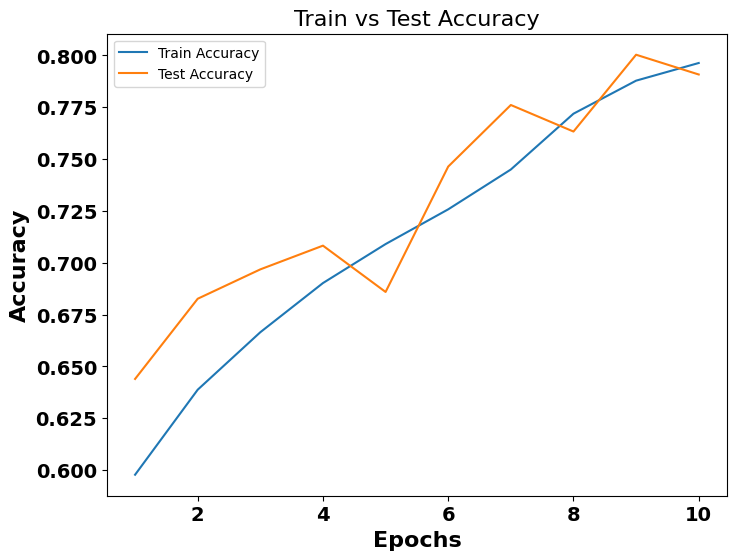

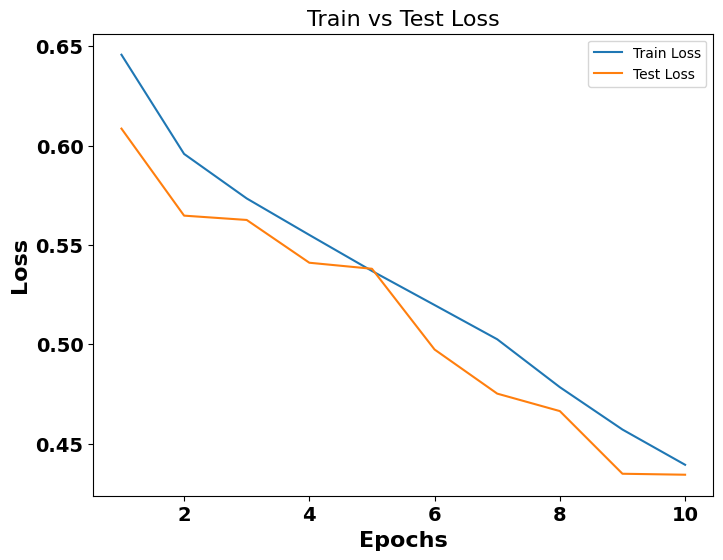

In [14]:
import matplotlib.pyplot as plt

# Data
epochs = range(1, num_epochs + 1)

# Plot accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.title('Train vs Test Accuracy', fontsize=16)
plt.legend()
plt.show()

# Plot loss curves
plt.figure(figsize=(8, 6))  # Ensure the same size as the accuracy plot
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.title('Train vs Test Loss', fontsize=16)
plt.legend()
plt.show()


# GRAD CAM

In [15]:
import torch
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots

class GradCAM_GNN:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Register forward and backward hooks on the target layer
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def generate_cam(self, data):
        self.model.eval()

        # Forward pass on the single sample
        output = self.model(data)

        # Backward pass to compute gradients
        self.model.zero_grad()
        output.backward()

        # Generate the CAM by multiplying the activations with the gradients
        cam = self.gradients * self.activations  # Shape: [hidden_channels, num_nodes]

        # Average across the channels (feature maps) to get the final CAM per node
        node_cam = cam.mean(dim=0)  # Shape: [num_nodes]

        # Normalize the node CAM to [0, 1]
        node_cam = node_cam - node_cam.min()
        node_cam = node_cam / node_cam.max()

        # Calculate edge importance by averaging the CAM values of the connected nodes
        edge_index = data.edge_index.cpu().numpy()
        edge_cam = []
        for i in range(edge_index.shape[1]):
            src, dst = edge_index[:, i]
            edge_imp = (node_cam[src] + node_cam[dst]) / 2.0  # Averaging node CAMs for the edge
            edge_cam.append(edge_imp.item())

        edge_cam = np.array(edge_cam)

        return node_cam.detach().cpu().numpy(), edge_cam

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

# Visualization function for a single sample in 3D using Plotly with color scale
def visualize_human_skeleton_3d_plotly(cam, data, title="3D Grad-CAM Visualization"):
    node_cam, edge_cam = cam
    node_positions = data.x[:, :3].cpu().numpy()  # Assume first 3 columns are X, Y, Z

    # Create a scatter plot for the joints
    scatter = go.Scatter3d(
        x=node_positions[:, 0],
        y=node_positions[:, 1],
        z=node_positions[:, 2],
        mode='markers+text',
        text=[f'{i}' for i in range(node_positions.shape[0])],
        marker=dict(
            size=8,
            color=node_cam,
            colorscale='Viridis',
            colorbar=dict(title="Node Grad-CAM Value", x=0.9),  # Add color bar for node Grad-CAM values
            opacity=0.8
        )
    )

    # Create lines for the edges (bones)
    edge_index = data.edge_index.cpu().numpy()
    edge_x = []
    edge_y = []
    edge_z = []
    edge_colors = []
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        edge_x.extend([node_positions[src, 0], node_positions[dst, 0], None])
        edge_y.extend([node_positions[src, 1], node_positions[dst, 1], None])
        edge_z.extend([node_positions[src, 2], node_positions[dst, 2], None])
        edge_colors.extend([edge_cam[i], edge_cam[i], edge_cam[i]])  # Use the edge importance for coloring

    # Ensure that there are no None values in edge_colors
    edge_colors = np.array(edge_colors)
    edge_colors = np.nan_to_num(edge_colors, nan=0.0)  # Replace None or NaN with 0.0

    lines = go.Scatter3d(
        x=edge_x,
        y=edge_y,
        z=edge_z,
        mode='lines',
        line=dict(
            color=edge_colors,
            colorscale='Viridis',
            width=4,
            colorbar=dict(title="Edge Grad-CAM Value", x=1.05)  # Position the edge color bar separately
        ),
        hoverinfo='none'
    )

    # Combine the scatter plot and lines into a single figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])
    fig.add_trace(scatter)
    fig.add_trace(lines)

    # Set the layout for better visualization, remove background and ticks
    fig.update_layout(
        scene=dict(
            xaxis=dict(title='X', showgrid=False, backgroundcolor="white", showticklabels=False),
            yaxis=dict(title='Y', showgrid=False, backgroundcolor="white", showticklabels=False),
            zaxis=dict(title='Z', showgrid=False, backgroundcolor="white", showticklabels=False),
            aspectmode='cube',
            bgcolor="white"  # Set overall scene background color to white
        ),
        margin=dict(l=0, r=0, b=0, t=0),
        paper_bgcolor="white",  # Set the background color of the figure
        plot_bgcolor="white",  # Set the background color of the plot area
        title=title,
        showlegend=False
    )

    fig.show()




### GRAD CAM PLOT

In [16]:
# Specify the patient ID you want to visualize
patient_id = '047-MW'  # Replace with actual patient ID
# Filter the dataset for the specific patient
patient_data = dataframe[dataframe['patientID'] == patient_id]  # Assuming dataframe has 'patientID' column
patient_dataset = SkeletonDataset(patient_data)

# Create a DataLoader for the specific patient
patient_loader = DataLoader(patient_dataset, batch_size=1, shuffle=False)  # Batch size 1 to load one sample at a time

target_layer = model.gcn2 # Example target layer
grad_cam = GradCAM_GNN(model, target_layer)

# Specify which data points you want to plot
points_to_plot = [80]  # Change this list to include the desired data points

# Loop through the DataLoader and select the specified data points
for i, single_sample in enumerate(patient_loader, 1):  # Start index from 1
    if i in points_to_plot:
        print(f"Visualizing {i}-th data point for patient {patient_id}... and Layer {target_layer}")

        single_sample = single_sample.to(device)

        # Generate and visualize the CAM for this single patient sample
        cam = grad_cam.generate_cam(single_sample)
        visualize_human_skeleton_3d_plotly(cam, single_sample, title=f"Grad-CAM for Patient {patient_id}, Data Point {i}")

# Remove the hooks to clean up
grad_cam.remove_hooks()

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Visualizing 80-th data point for patient 047-MW... and Layer GCNConv(128, 128)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [17]:
# Specify the patient ID you want to visualize
patient_id = '037-MA'  # Replace with actual patient ID
# Filter the dataset for the specific patient
patient_data = dataframe[dataframe['patientID'] == patient_id]  # Assuming dataframe has 'patientID' column
patient_dataset = SkeletonDataset(patient_data)

# Create a DataLoader for the specific patient
patient_loader = DataLoader(patient_dataset, batch_size=1, shuffle=False)  # Batch size 1 to load one sample at a time

target_layer = model.gcn2  # Example target layer
grad_cam = GradCAM_GNN(model, target_layer)

# Specify which data points you want to plot
points_to_plot = [80]  # Change this list to include the desired data points

# Loop through the DataLoader and select the specified data points
for i, single_sample in enumerate(patient_loader, 1):  # Start index from 1
    if i in points_to_plot:
        print(f"Visualizing {i}-th data point for patient {patient_id}... and Layer {target_layer}")

        single_sample = single_sample.to(device)

        # Generate and visualize the CAM for this single patient sample
        cam = grad_cam.generate_cam(single_sample)
        visualize_human_skeleton_3d_plotly(cam, single_sample, title=f"Grad-CAM for Patient {patient_id}, Data Point {i}")

# Remove the hooks to clean up
grad_cam.remove_hooks()

Visualizing 80-th data point for patient 037-MA... and Layer GCNConv(128, 128)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.

